# 4. Learning CatBoost model

Here we learn CatBoost model with our dataset

## 0. Preparation

In [24]:
import pandas as pd
import json
import torch
from sklearn.metrics.pairwise import paired_distances
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, CatBoostRanker, Pool, cv
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from sklearn.preprocessing import LabelEncoder, StandardScaler
from catboost.utils import get_roc_curve, get_fpr_curve, get_fnr_curve, select_threshold
from sklearn import metrics
import os
from imblearn.over_sampling import SMOTE
from PIL import Image
from sklearn.metrics import accuracy_score

## 1. Representation of class and functions

### 1.1. Dataset class: it is responsible for all operations with dataset

In [2]:
path = '/Users/mishafoniakov/Documents/Thesis'
def file(folder, file):
    return os.path.join(path, folder, file)

In [3]:
class Dataset:
    def __init__(self):
        pass
        
    def json_file_opening(self, json_file, img, feature_1, feature_2, 
                          dictionary=False, reshaping=False, tensor=False):
        with open(json_file, 'r') as file:
            img_features = [(json.loads(line)[img],
                 json.loads(line)[feature_1],
                 json.loads(line)[feature_2])
                  for line in file]
        img_list = [feature[0] for feature in img_features]
        feature_1_list = [feature[1] for feature in img_features]
        feature_2_list = [feature[2] for feature in img_features]
        if dictionary == False:
            return img_list, feature_1_list, feature_2_list
        else:
            dict_1_list, dict_2_list = {}, {}
            assert len(img_list) == len(feature_1_list)
            assert len(img_list) == len(feature_2_list)
            for i in range(len(img_list)):
                if reshaping == True:
                    dict_1_list[img_list[i]] = np.array(feature_1_list[i]).reshape(1, -1)
                    dict_2_list[img_list[i]] = np.array(feature_2_list[i]).reshape(1, -1)
                elif tensor == True:
                    dict_1_list[img_list[i]] = torch.FloatTensor(feature_1_list[i]).unsqueeze(dim=0)
                    dict_2_list[img_list[i]] = torch.FloatTensor(feature_2_list[i]).unsqueeze(dim=0)
                else:
                    dict_1_list[img_list[i]] = feature_1_list[i]
                    dict_2_list[img_list[i]] = feature_2_list[i]
            return dict_1_list, dict_2_list
    
    def dataset_preparation(self, dataframe):
        train, test_0 = train_test_split(dataframe, test_size=0.4, random_state=13)
        val, test = train_test_split(test_0, test_size=0.5, random_state=13)
        train = train.sort_values(by=['query'], ascending=True)
        test = test.sort_values(by=['query'], ascending=True)
        val = val.sort_values(by=['query'], ascending=True)
        sc = StandardScaler()
        scaled_features = ['clip_cossim', 'clip_l2', 'bert_cossim', 'bert_l2']
        train[scaled_features] = sc.fit_transform(train[scaled_features])
        test[scaled_features] = sc.fit_transform(test[scaled_features])
        val[scaled_features] = sc.fit_transform(val[scaled_features])
        y_train = train['target_y']
        q_train = train['query']
        X_train = train.drop(['target_y', 'query'], axis=1)
        y_test = test['target_y']
        q_test = test['query']
        X_test = test.drop(['target_y', 'query'], axis=1)
        y_val = val['target_y']
        q_val = val['query']
        X_val = val.drop(['target_y', 'query'], axis=1)
        return X_train, y_train, q_train, X_test, y_test, q_test, X_val, y_val, q_val

### 1.2. Analytics class: it is responsible for all analytics

In [4]:
class ImageAnalytics:
    def __init__(self, dataframe):
        self.dataframe = dataframe
    
    def metrics_count(self):
        clip_1 = list(self.dataframe['img_clip_1'].values)
        clip_2 = list(self.dataframe['img_clip_2'].values)
        bert_1 = list(self.dataframe['img_bert_1'].values)
        bert_2 = list(self.dataframe['img_bert_2'].values)
        assert len(clip_1) == len(clip_2)
        n = len(clip_1)
        clip_cossim, clip_l2, bert_cossim, bert_l2 = [0] * n, [0] * n, [0] * n, [0] * n
        for i in range(n):
            clip_cossim[i] = (torch.nn.functional.cosine_similarity(clip_1[i], clip_2[i])).item()
            clip_l2[i] = paired_distances(clip_1[i], clip_2[i], metric='l2')[0]
            bert_cossim[i] = (torch.nn.functional.cosine_similarity(bert_1[i], bert_2[i])).item()
            bert_l2[i] = paired_distances(bert_1[i], bert_2[i], metric='l2')[0]
        self.dataframe['clip_cossim'] = clip_cossim
        self.dataframe['clip_l2'] = clip_l2
        self.dataframe['bert_cossim'] = bert_cossim
        self.dataframe['bert_l2'] = bert_l2
        return self.dataframe
        

### 1.3. Catboosy class: it is responsible for all operations with CatBoost model

In [5]:
class CatboostClass:
    def __init__(self):
        pass
    
    def roc_curve(self, model, val_pool):
        curve = get_roc_curve(model, val_pool)
        (fpr, tpr, thresholds) = curve
        roc_auc = metrics.auc(fpr, tpr)
        plt.figure(figsize=(16, 8))
        lw = 2
        plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.grid(True)
        plt.xlabel('False Positive Rate', fontsize=16)
        plt.ylabel('True Positive Rate', fontsize=16)
        plt.title('Receiver operating characteristic', fontsize=20)
        plt.legend(loc='lower right', fontsize=16)
        plt.show()
    
    def fpr_fnr(self, model, val_pool):
        curve = get_roc_curve(model, val_pool)
        (fpr, tpr, thresholds) = curve
        (thresholds, fpr) = get_fpr_curve(curve=curve)
        (thresholds, fnr) = get_fnr_curve(curve=curve)
        plt.figure(figsize=(16, 8))
        lw = 2
        plt.plot(thresholds, fpr, color='blue', lw=lw, label='FPR', alpha=0.5)
        plt.plot(thresholds, fnr, color='green', lw=lw, label='FNR', alpha=0.5)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.grid(True)
        plt.xlabel('Threshold', fontsize=16)
        plt.ylabel('Error Rate', fontsize=16)
        plt.title('FPR-FNR curves', fontsize=20)
        plt.legend(loc='lower right', fontsize=16)
        plt.show()
        fnr = (select_threshold(model=model, data=val_pool, FNR=0.01))
        fpr = (select_threshold(model=model, data=val_pool, FPR=0.01))
        return f'FNR = {fnr}, FPR = {fpr}'

# 2. Dataset preparation

In [6]:
# We open datasets with pairs with CLIP and BERT vectors
img_data = pd.read_csv('/Users/mishafoniakov/Documents/Thesis/Dataset_preparation/img_data.csv')
text_data = pd.read_csv('/Users/mishafoniakov/Documents/Thesis/Dataset_preparation/text_data.csv')

In [7]:
# we open datasets fro CLIP and BERT vectors
dataset = Dataset()
img_clip, img_bert = dataset.json_file_opening('/Users/mishafoniakov/Documents/Thesis/Dataset_preparation/clip_bert.json', 
                                     'img', 'clip', 'bert', dictionary=True, reshaping=False, tensor=True)

In [8]:
# we add query featuture
data = img_data.merge(text_data, how='inner', left_on=['img_clip_1', 'img_clip_2'], right_on=['img_bert_1', 'img_bert_2'])
le = LabelEncoder()
data['query'] = le.fit_transform(data['img_clip_1'])

In [9]:
#we extract clip and bert vector for pain
data['img_clip_1'] = data['img_clip_1'].apply(lambda x: img_clip.get(x))
data['img_clip_2'] = data['img_clip_2'].apply(lambda x: img_clip.get(x))
data['img_bert_1'] = data['img_bert_1'].apply(lambda x: img_bert.get(x))
data['img_bert_2'] = data['img_bert_2'].apply(lambda x: img_bert.get(x))
data = data.drop(['target_x'], axis=1)

In [10]:
# we count analytics
analytics = ImageAnalytics(data)
data = analytics.metrics_count()

In [17]:
#we preprocess the dataset
data['img_clip_1'] = data['img_clip_1'].apply(lambda x: x.numpy().reshape(512))
data['img_clip_2'] = data['img_clip_2'].apply(lambda x: x.numpy().reshape(512))
data['img_bert_1'] = data['img_bert_1'].apply(lambda x: x.numpy().reshape(768))
data['img_bert_2'] = data['img_bert_2'].apply(lambda x: x.numpy().reshape(768))

In [19]:
#data = pd.read_csv(file('Dataset_model', 'learning_pipeline.csv'))

In [21]:
# we preprocess the dataset and split by train, test, validation data
dataset = Dataset()
X_train, y_train, q_train, X_test, y_test, q_test, X_val, y_val, q_val = dataset.dataset_preparation(data)

In [22]:
# we use pool option for train and validation data
train = Pool(data=X_train, label=y_train, group_id=q_train, embedding_features=[0, 1, 2, 3])
val = Pool(data=X_val, label=y_val, group_id=q_val, embedding_features=[0, 1, 2, 3])

# 3. CatBoost model

In [23]:
catboost = CatBoostClassifier(iterations=2000, 
                          learning_rate=0.001,
                          max_depth=6,
                          loss_function='Logloss',
                          scale_pos_weight=2.64,
                          early_stopping_rounds=20,
                          custom_metric=['AUC', 'Accuracy', 'PFound'])

catboost.fit(train,
             eval_set=val,
             verbose=True,
             plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6921555	test: 0.6921349	best: 0.6921349 (0)	total: 15.9ms	remaining: 31.8s
1:	learn: 0.6911428	test: 0.6911061	best: 0.6911061 (1)	total: 30.9ms	remaining: 30.9s
2:	learn: 0.6902020	test: 0.6901605	best: 0.6901605 (2)	total: 42.9ms	remaining: 28.6s
3:	learn: 0.6892488	test: 0.6892119	best: 0.6892119 (3)	total: 57.2ms	remaining: 28.6s
4:	learn: 0.6882470	test: 0.6881870	best: 0.6881870 (4)	total: 71.5ms	remaining: 28.5s
5:	learn: 0.6872436	test: 0.6871816	best: 0.6871816 (5)	total: 86.3ms	remaining: 28.7s
6:	learn: 0.6862487	test: 0.6861755	best: 0.6861755 (6)	total: 101ms	remaining: 28.8s
7:	learn: 0.6853420	test: 0.6852641	best: 0.6852641 (7)	total: 115ms	remaining: 28.6s
8:	learn: 0.6844000	test: 0.6843066	best: 0.6843066 (8)	total: 129ms	remaining: 28.5s
9:	learn: 0.6834018	test: 0.6832982	best: 0.6832982 (9)	total: 143ms	remaining: 28.5s
10:	learn: 0.6824610	test: 0.6823559	best: 0.6823559 (10)	total: 158ms	remaining: 28.5s
11:	learn: 0.6814751	test: 0.6813551	best: 0.6

# 4. Results

### 4.1. ROC-AUC

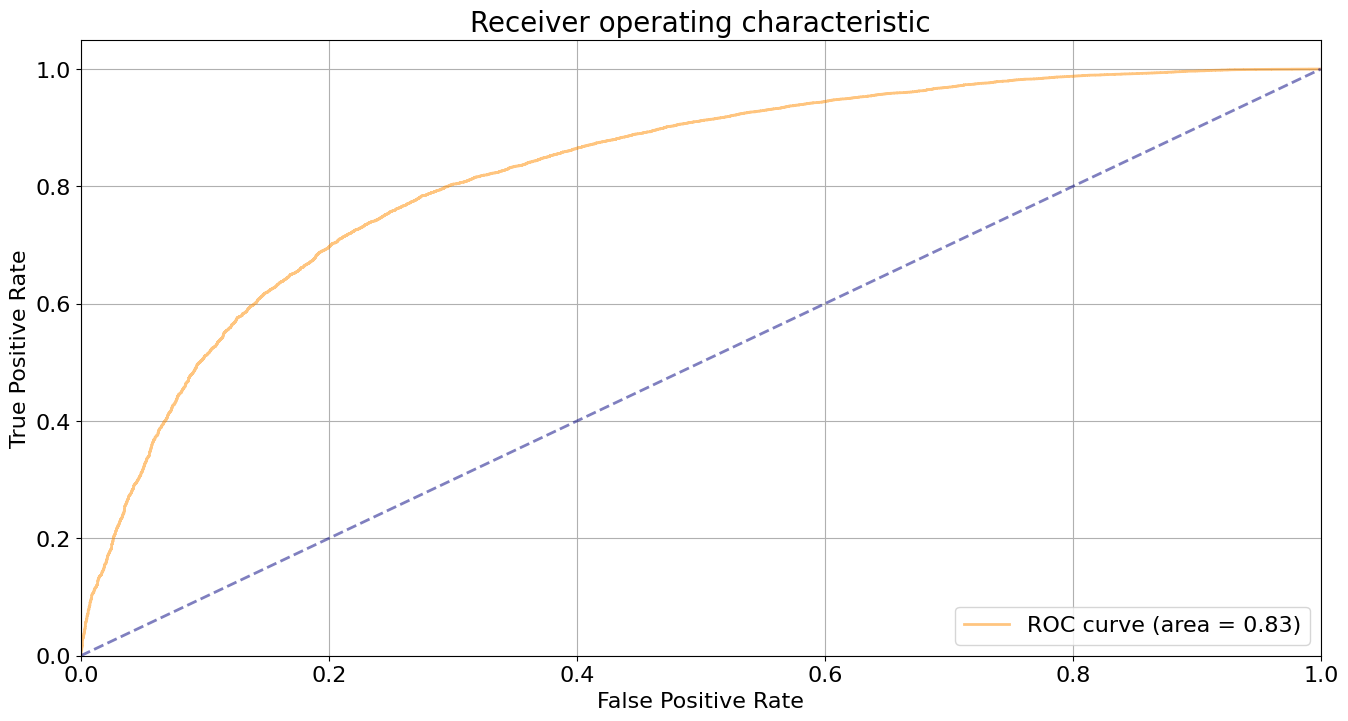

In [34]:
catboostclass = CatboostClass()
catboostclass.roc_curve(catboost, val)

### 4.2. FPR-FNR curves

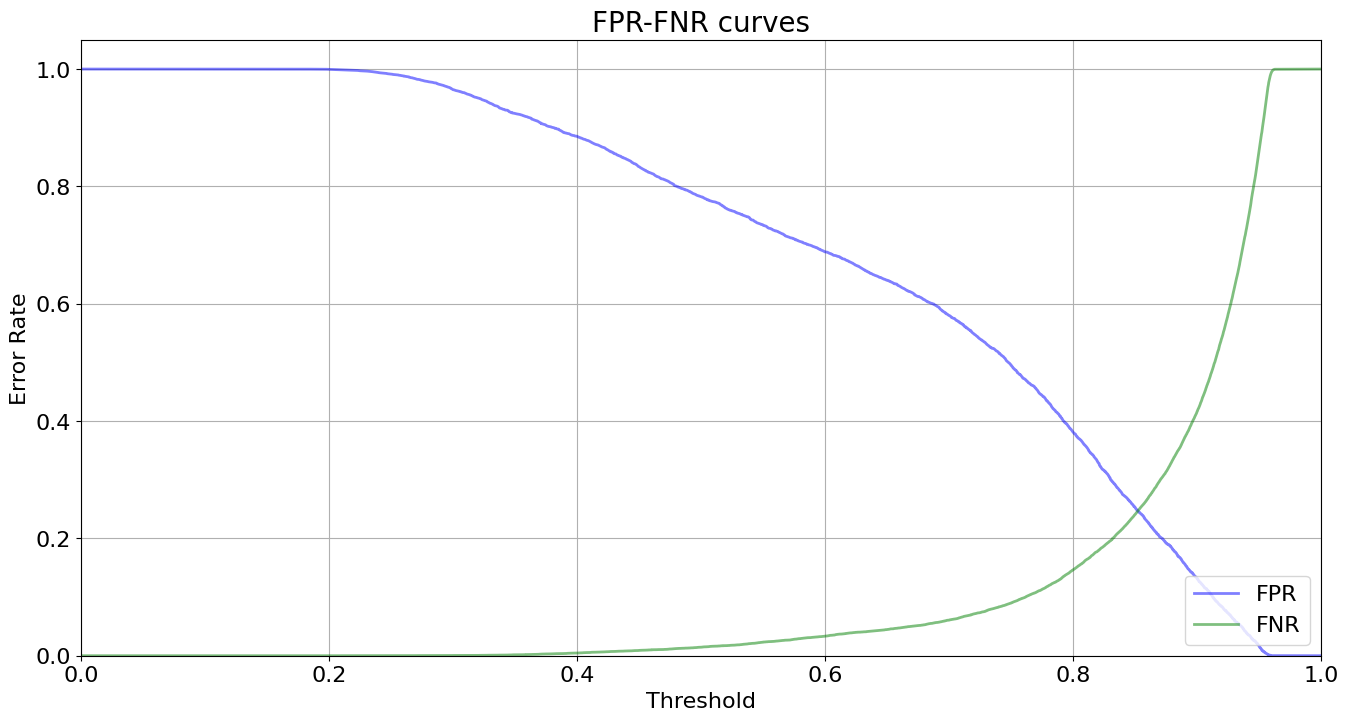

'FNR = 0.46046270109709075, FPR = 0.9525372052196104'

In [26]:
catboostclass.fpr_fnr(catboost, val)

In [27]:
catboost.save_model('/Users/mishafoniakov/Documents/Thesis/Dataset_model/catboost_model.bin')
catboost.save_model('/Users/mishafoniakov/Documents/Thesis/Dataset_model/catboost_model.json', format='json')

### 4.3. Feature importance

In [81]:
catboost.get_feature_importance(prettified=True)

,Feature Id,Importances
0,clip_l2,36.124087
1,clip_cossim,23.903652
2,img_clip_2,21.466410
3,img_clip_1,14.358827
4,img_bert_2,1.670457
5,img_bert_1,1.553855
6,bert_l2,0.473535
7,bert_cossim,0.449177
